In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import linear_model

from scipy import optimize
import matplotlib.pyplot as plt


It is regression problem, where we will use LinearRegression algorithm by predicting medical insurance cost

In [ ]:
data = pd.read_csv('insurance.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
print(f'Age : {data.age.dtype}')
print(f'Sex : {data.sex.dtype}')
print(f'BMI : {data.bmi.dtype}')
print(f'Children : {data.children.dtype}')
print(f'Smoker : {data.smoker.dtype}')
print(f'region : {data.region.dtype}')
print(f'charges : {data.charges.dtype}')

Age : int64
Sex : object
BMI : float64
Children : int64
Smoker : object
region : object
charges : float64


There are 7 columns, 4 numeric (integer, float) and 3 categorical (object)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Seems no missing values, non-null. Try to use isna() function to see missing values, but by that output all of rows has False, if there is True it means that there is missing value.

In [ ]:
print(data.isna())

# Provide sum of missing values

print(data.isna().sum())

        age    sex    bmi  children  smoker  region  charges
0     False  False  False     False   False   False    False
1     False  False  False     False   False   False    False
2     False  False  False     False   False   False    False
3     False  False  False     False   False   False    False
4     False  False  False     False   False   False    False
...     ...    ...    ...       ...     ...     ...      ...
1333  False  False  False     False   False   False    False
1334  False  False  False     False   False   False    False
1335  False  False  False     False   False   False    False
1336  False  False  False     False   False   False    False
1337  False  False  False     False   False   False    False

[1338 rows x 7 columns]
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [ ]:
print("Numbers of duplicated rows :",data.duplicated().sum())

Numbers of duplicated rows : 1


In [ ]:
#dropping the duplicated rows 
data = data.drop_duplicates(keep="first")
print("After removing,now number of duplicated rows are:",data.duplicated().sum())

After removing,now number of duplicated rows are: 0


In [ ]:
#check the correlation between terget and each of columns
data.corr()["charges"]

age         0.298308
bmi         0.198401
children    0.067389
charges     1.000000
Name: charges, dtype: float64

In [ ]:
# Encode strings

def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df



In [ ]:
# add suffix to see regenerated columns of REGION
pd.get_dummies(data['region'], prefix='Changed')

,Changed_northeast,Changed_northwest,Changed_southeast,Changed_southwest
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
1333,0,1,0,0
1334,1,0,0,0
1335,0,0,1,0
1336,0,0,0,1


In [ ]:
# add suffix to see regenerated columns of GENDER
pd.get_dummies(data['sex'], prefix='GENDER')

,GENDER_female,GENDER_male
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
1333,0,1
1334,1,0
1335,1,0
1336,1,0


In [ ]:
def preprocess_inputs(df, scaler, train_size):
    df = df.copy()
    df = binary_encode(df, 'sex', 'male')
    df = binary_encode(df, 'smoker', 'yes')

    # One hot encode of children and region
    df = onehot_encode(df, 'children', 'ch')
    df = onehot_encode(df, 'region', 're')

    # Split of in X and Y
    X = df.drop('charges', axis=1).copy()
    y = df['charges'].copy()
    normalized_X = (X - np.min(X)) / (np.max(X) - np.min(X))
    # Scale X with different scalers
    normalized_X = pd.DataFrame(scaler.fit_transform(normalized_X), columns=normalized_X.columns)

    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, train_size=train_size, random_state=123)

    return X_train, X_test, y_train, y_test, normalized_X, y


In [ ]:
# train_size=0.7 --> 70% of train set

X_train, X_test, y_train, y_test, X, y = preprocess_inputs(data, StandardScaler(), train_size=0.7)
print("X train: ", X_train, '\n', "Y train: ", y_train )
print("X_test: ", X_test, '\n', "Y test", y_test)

X train:             age       sex       bmi    smoker      ch_0      ch_1      ch_2  \
616   0.696474  0.990324 -0.830321  1.969660 -0.866025 -0.565546  2.137951   
373  -0.941810  0.990324  0.366756  1.969660 -0.866025 -0.565546  2.137951   
299   0.625245 -1.009771 -0.292456 -0.507702 -0.866025  1.768203 -0.467738   
376  -0.015823 -1.009771 -0.946749  1.969660 -0.866025 -0.565546 -0.467738   
384   0.340326  0.990324 -1.398523 -0.507702 -0.866025 -0.565546  2.137951   
...        ...       ...       ...       ...       ...       ...       ...   
1238 -1.013039 -1.009771  1.880321 -0.507702 -0.866025  1.768203 -0.467738   
1147  1.123853  0.990324 -1.502652 -0.507702 -0.866025  1.768203 -0.467738   
106  -1.440418 -1.009771 -0.371168 -0.507702 -0.866025  1.768203 -0.467738   
1041 -1.369188  0.990324  0.003534  1.969660  1.154701 -0.565546 -0.467738   
1122 -0.870580 -1.009771  0.283945 -0.507702 -0.866025  1.768203 -0.467738   

          ch_3      ch_4      ch_5  re_northeast  re_

In [ ]:
print("X shape - ", X.shape, '\n', "Y shape - ", y.shape)
print("X_train shape - ", X_train.shape, '\n', "Y_train shape - ", y_train.shape)
print("X_test shape - ", X_test.shape, '\n', "Y_test shape - ", y_test.shape)

X shape -  (1337, 14) 
 Y shape -  (1337,)
X_train shape -  (935, 14) 
 Y_train shape -  (935,)
X_test shape -  (402, 14) 
 Y_test shape -  (402,)


In [ ]:
data.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


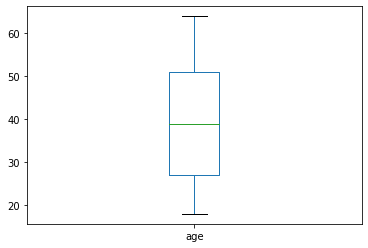

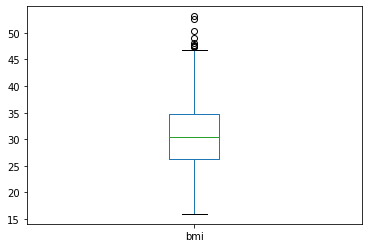

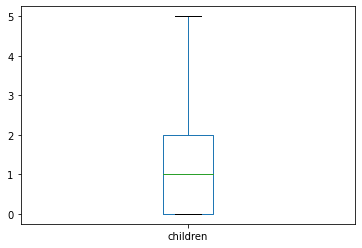

In [ ]:
# define function called "plot_boxplot" to see outliers in each input

def plot_boxplot(data, ft):
    data.boxplot(column=[ft])
    plt.grid(False)
    plt.show()

plot_boxplot(data, "age")
plot_boxplot(data, "bmi")
plot_boxplot(data, "children")

There are 1 outliers in BMI

In [ ]:
# Remove outliers
# IQR method
# IQR = Q3 - Q1
# +/- 1.5 * IQR

def outliers(data, ft):
    Q1 = data[ft].quantile(0.25)
    Q3 = data[ft].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

# indexes of outliers
    ls = data.index[ (data[ft] < lower_bound) | (data[ft] > upper_bound)]

    return ls

In [ ]:
index_list = []
for feature in ['age', 'bmi', 'children']:
    index_list.extend(outliers(data, feature))

In [ ]:
# indexes of outliers in BMI
index_list

[116, 286, 401, 543, 847, 860, 1047, 1088, 1317]

In [ ]:
# define a function called "remove" which returns a cleaned dataframe without outliers

def remove(data, ls):
    ls = sorted(set(ls))
    data = data.drop(ls)
    return data


In [ ]:
data_cleaned = remove(data, index_list)
print("Before removing outliers: ", data.shape)
print("After removing outliers: ", data_cleaned.shape)

Before removing outliers:  (1337, 7)
After removing outliers:  (1328, 7)


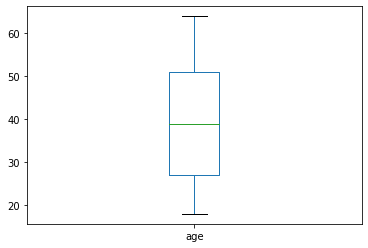

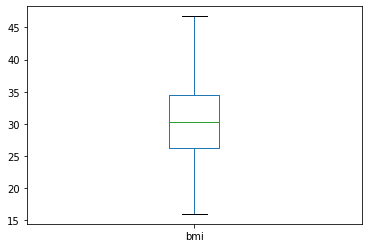

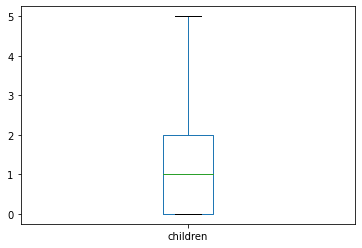

In [ ]:
plot_boxplot(data_cleaned, "age")
plot_boxplot(data_cleaned, "bmi")
plot_boxplot(data_cleaned, "children")

Data Visualisation part

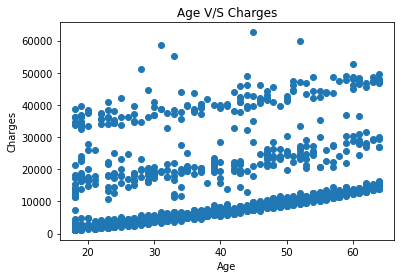

In [ ]:
plt.scatter(data_cleaned.age, data_cleaned.charges)
plt.title("Age V/S Charges")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

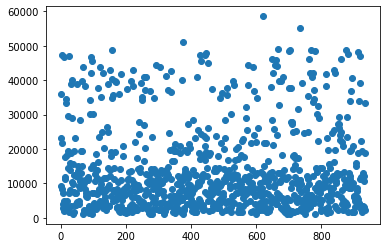

In [ ]:
# spaced array for X_train

X_train_array = np.arange(0,len(X_train),1)
plt.scatter(X_train_array, y_train)

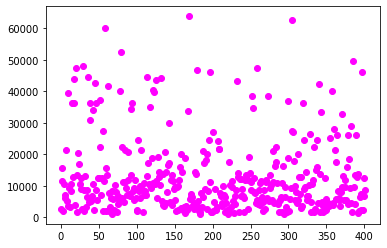

In [ ]:
# spaced array for X_test

X_test_array = np.arange(0,len(X_test),1)
plt.scatter(X_test_array, y_test, c="magenta")

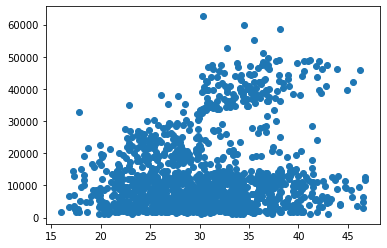

In [ ]:
plt.scatter(data_cleaned['bmi'],data_cleaned['charges'])

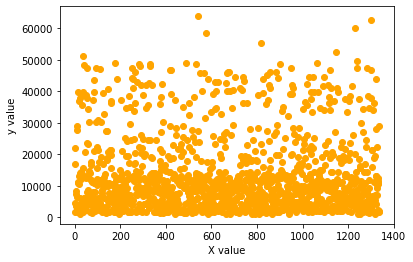

In [ ]:
X_array = np.arange(0,len(X),1)
plt.scatter(X_array, y, color="orange")
plt.xlabel("X value")
plt.ylabel("y value")
plt.show()

In [ ]:
X

,age,sex,bmi,smoker,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,re_northeast,re_northwest,re_southeast,re_southwest
0,-1.440418,-1.009771,-0.453160,1.969660,1.154701,-0.565546,-0.467738,-0.364761,-0.138039,-0.116819,-0.565546,-0.565546,-0.611638,1.764609
1,-1.511647,0.990324,0.509422,-0.507702,-0.866025,1.768203,-0.467738,-0.364761,-0.138039,-0.116819,-0.565546,-0.565546,1.634955,-0.566698
2,-0.799350,0.990324,0.383155,-0.507702,-0.866025,-0.565546,-0.467738,2.741518,-0.138039,-0.116819,-0.565546,-0.565546,1.634955,-0.566698
3,-0.443201,0.990324,-1.305052,-0.507702,1.154701,-0.565546,-0.467738,-0.364761,-0.138039,-0.116819,-0.565546,1.768203,-0.611638,-0.566698
4,-0.514431,0.990324,-0.292456,-0.507702,1.154701,-0.565546,-0.467738,-0.364761,-0.138039,-0.116819,-0.565546,1.768203,-0.611638,-0.566698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,0.767704,0.990324,0.050269,-0.507702,-0.866025,-0.565546,-0.467738,2.741518,-0.138039,-0.116819,-0.565546,1.768203,-0.611638,-0.566698
1333,-1.511647,-1.009771,0.206053,-0.507702,1.154701,-0.565546,-0.467738,-0.364761,-0.138039,-0.116819,1.768203,-0.565546,-0.611638,-0.566698
1334,-1.511647,-1.009771,1.014490,-0.507702,1.154701,-0.565546,-0.467738,-0.364761,-0.138039,-0.116819,-0.565546,-0.565546,1.634955,-0.566698
1335,-1.297958,-1.009771,-0.797524,-0.507702,1.154701,-0.565546,-0.467738,-0.364761,-0.138039,-0.116819,-0.565546,-0.565546,-0.611638,1.764609


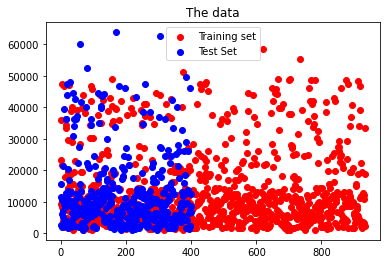

In [ ]:
X_train_array = np.arange(0,len(X_train),1)
X_test_array = np.arange(0,len(X_test),1)

plt.figure(figsize=(6, 4))
plt.scatter(X_train_array, y_train, color="red", label="Training set")
plt.scatter(X_test_array, y_test, color="blue", label="Test Set")
plt.title("The data")
plt.legend(loc="best")

In [ ]:
def linearRegressionCost(X, y, theta):
    m = y.size
    J_list = []
    theta_list = []
    alpha = 0.01
    epoch = 1500
    for i in range(epoch):
        h = X.dot(theta)
        J = 1/(2*m) * ((h - y).T @ (h - y)) 
        J_list.append(J)
        grad = 1/m * X.T.dot(h-y)
        theta = theta - alpha * grad
        theta_list.append(theta)
    return J, grad, J_list

m = y_train.size

theta = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
J, _, _ = linearRegressionCost(np.concatenate([np.ones((m, 1)), X_train], axis=1), y_train, theta)

In [ ]:
J, grad, _  = linearRegressionCost(np.concatenate([np.ones((m, 1)), X_train], axis=1), y_train, theta)
print("Gradient descent: ", grad)

Gradient descent:  [-0.00358144 -0.00167888  0.01027706 -0.0144147  -0.012916   -0.00106687
 -0.00104608  0.00060034  0.00478854 -0.0009507  -0.0057874  -0.00244065
 -0.00452886  0.00874406 -0.00211156]


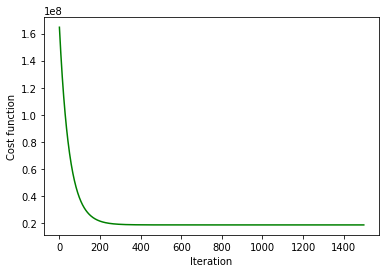

In [ ]:
J, grad, J_list = linearRegressionCost(np.concatenate([np.ones((m, 1)), X_train], axis=1), y_train, theta)
plt.plot(range(len(J_list)), J_list, c = 'green')
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.show()

In [ ]:
def check_linear(X, y, theta):
    m = y.size
    J = 0
    grad = np.zeros(theta.shape)
    h = X.dot(theta)
    J = 1/(2*m) * np.sum((h-y)**2)
    grad = 1/m * X.T.dot(h-y)
    for i in range(1, len(grad)):
        grad_others = 1/m * X.T.dot(h-y)
        grad[i] = grad_others[i]
    return J, grad, h

In [ ]:
m_check = y_train.size
theta_check = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
J_check, _, _ = check_linear(np.concatenate([np.ones((m_check, 1)), X_train], axis=1), y_train, theta_check)
print('Cost: ', J_check)



Cost:  164645962.18380898


In [ ]:
J_check, grad, h = check_linear(np.concatenate([np.ones((m_check, 1)), X_train], axis=1), y_train, theta_check)
print(h)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train,pred_train))
RMSE_test = np.sqrt(mean_squared_error(y_test,pred_test))


print("RMSE for traning set is: ", RMSE_train)
print("RMSE for testing set is: ", RMSE_test)
print(pred_train)

RMSE for traning set is:  6167.2583498988615
RMSE for testing set is:  5877.522506342703
[ 3.38116229e+04  3.02276229e+04  1.05156229e+04  2.93316229e+04
  8.53162289e+03  3.98276229e+04  8.40362289e+03  3.98762289e+03
  9.87562289e+03  4.49962289e+03  3.66916229e+04  6.29162289e+03
  1.30756229e+04  2.51076229e+04  1.40356229e+04  1.52516229e+04
  4.37162289e+03  2.63236229e+04  7.82762289e+03  2.32516229e+04
  2.57962289e+03  3.75876229e+04  1.85796229e+04  2.87556229e+04
  3.93156229e+04  4.49962289e+03  1.12836229e+04  1.03876229e+04
  1.23716229e+04  2.26116229e+04  7.57162289e+03  7.23622892e+02
  2.93956229e+04  1.17956229e+04  1.01316229e+04  3.08036229e+04
  2.46596229e+04  5.84362289e+03  1.42276229e+04  2.70916229e+04
  1.87562289e+03  1.40356229e+04  1.13476229e+04  5.90762289e+03
  9.55562289e+03  3.20196229e+04  7.87622892e+02  5.58762289e+03
  1.32676229e+04  7.69962289e+03  3.41956229e+04  7.25162289e+03
  1.47396229e+04  1.31396229e+04  1.15396229e+04  2.32362289e+03
 

In [ ]:
J_check, grad_check = check_linear(np.concatenate([np.ones((m_check, 1)), X], axis=1), y, theta_check)
print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))

Gradient at theta = [1, 1]:  [-0.003581, -0.001680] 


In [ ]:
def trainLinearReg(linearRegressionCost, X, y):
    initial_theta = np.zeros(X.shape[1])
    maxiter=1500
    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegressionCost(X, y, t)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return res.x
    

In [ ]:
def learningCurve_check(X, y, Xval, yval):
    m = y.size
    error_train = np.zeros(m)
    error_val   = np.zeros(m)
    for i in range(1, len(X)):
        theta =  trainLinearReg(check_linear, X[:i, :], y[:i])
        error_train[i-1] = check_linear(X[:i, :], y[:i], theta)[0]
        error_val[i-1] = check_linear(Xval, yval, theta)[0]
    return error_train, error_val

Text(0, 0.5, 'Error')

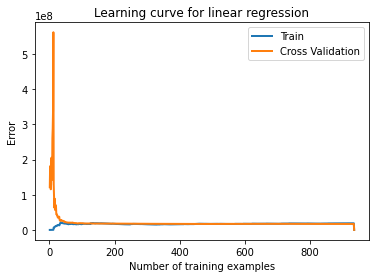

In [ ]:
X_aug = np.concatenate([np.ones((m, 1)), X_train], axis=1)
Xval_aug = np.concatenate([np.ones((y_test.size, 1)), X_test], axis=1)
error_train, error_val = learningCurve_check(X_aug, y_train, Xval_aug, y_test)

plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')


In [ ]:
epoch = 1500;
theta = np.zeros(14)

lr = 0.005;
theta_1, J_list_1 = grad(X_train, y_train, theta, lr, epoch)

lr = 0.01;
theta_2, J_list_2 = grad(X_train, y_train, theta, lr, epoch)

lr = 0.02;
theta_3, J_list_3 = grad(X_train, y_train, theta, lr, epoch)

lr = 0.03;
theta_4, J_list_4 = grad(X_train, y_train, theta, lr, epoch)

lr = 0.15;
theta_5, J_list_5 = grad(X_train, y_train, theta, lr, epoch)

plt.plot(list(range(epoch)), J_list_1, color ='purple', label = 'learnRate = 0.005')
plt.plot(list(range(epoch)), J_list_2, color ='red', label = 'learnRate = 0.01')
plt.plot(list(range(epoch)), J_list_3, color ='yellow', label = 'learnRate = 0.02')
plt.plot(list(range(epoch)), J_list_4, color ='green', label = 'learnRate = 0.03')
plt.plot(list(range(epoch)), J_list_5, color ='blue', label = 'learnRate = 0.15')

plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Testing different Learning Rates On Convergence of Gradient Descent")
plt.legend()

In [ ]:
from sklearn.metrics import r2_score
epoch = 1500
lr = 0.15
theta, J_list = grad(X_train, y_train, theta, lr, epoch)
y_pred = X_test.dot(theta)
r2 = r2_score(y_test,y_pred)
print("R2 score: "+str(r2))
pred_data = {"y_test":y_test,"y_pred":y_pred}
pd.DataFrame(data=pred_data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ee63fff4-a5bd-49e4-b9ef-da15b3f6525c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>